## Random Cut Forest - Machie temperature system failure (NAB)
Prima di utilizzare questo script, bisogna caricare il file csv dei dati [machine_temperature_system_failure.csv](https://drive.google.com/file/d/1-P2RkOALR9EF2oqA4D8jdlVxVaqtGdej/view?usp=sharing).
Siccome l'algoritmo di [Robust Random Cut Forest](https://github.com/kLabUM/rrcf) non è presente su Colab, bisogna installarlo.

### Anomalie
Ci sono 3 anomalie nel dataset caricato:
* 2 anomalie spaziali
* 1 anomalia temporale

In [5]:
!pip install rrcf

In [6]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rrcf

In [7]:
# Costanti
DATASET_PATH = 'machine_temperature_system_failure.csv'

In [8]:
# Caricamento dataset
temperature = pd.read_csv(DATASET_PATH, index_col=0)
temperature.head()

,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [9]:
# Preparazione dati
temperature.index = pd.to_datetime(temperature.index)
dataset = temperature['value'].astype(float).values
dataset

array([73.96732207, 74.935882  , 76.12416182, ..., 97.13546835,
       98.05685212, 96.90386085])

In [10]:
# Set parametri albero
num_trees = 200
#shingle_size = 12 # Stream di dati di 1 ora
#shingle_size = 12 * 12 # Stream di dati di 12 ore
shingle_size = 12 * 24 # Stream di dati di 1 giorno
tree_size = 1000

In [11]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(dataset, size=shingle_size)
points = np.vstack([point for point in points])
n = points.shape[0]
sample_size_range = (n // tree_size, tree_size)

In [12]:
# Creazione random forest
forest = []
while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(points[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [13]:
# Setup valori codisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)

In [14]:
# Merge alberi decisione
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)

In [15]:
# Calcolo media codisp
avg_codisp /= index
avg_codisp.index = temperature.iloc[(shingle_size - 1):].index

In [16]:
# Creazione eventi anomali
events = {
  'spatial1'     : ('2013-12-15 12:00:00',
                    '2013-12-17 00:00:00'),
  'temporal1'    : ('2014-02-02 12:00:00',
                    '2014-02-04 00:00:00'),
  'spatial2'     : ('2014-02-07 00:00:00',
                    '2014-02-10 00:00:00'),
}
temperature['event'] = np.zeros(len(temperature))
for event, duration in events.items():
    start, end = duration
    temperature.loc[start:end, 'event'] = 1

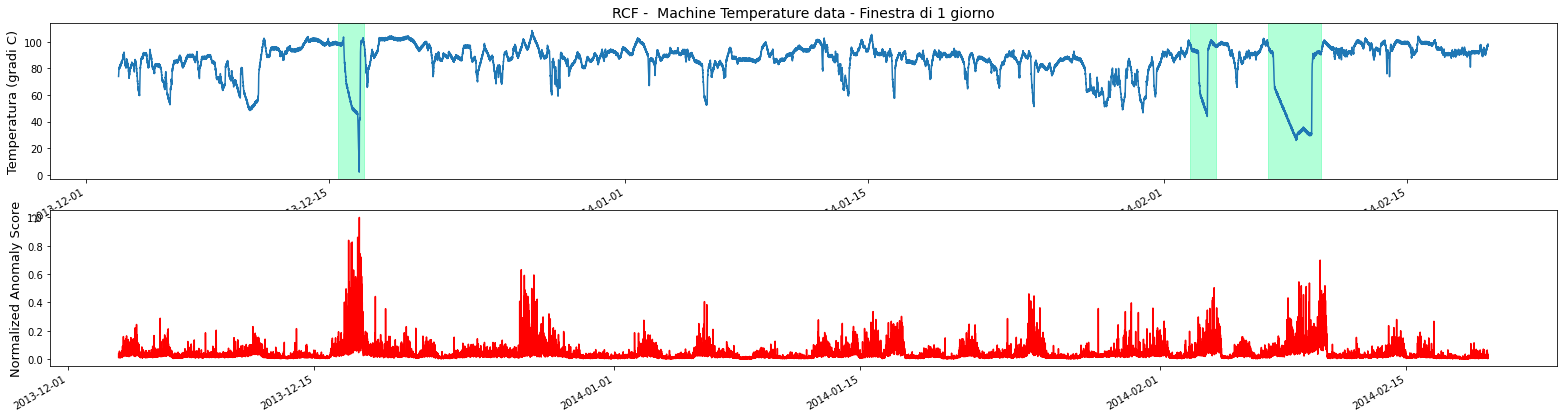

In [17]:
# Plot dei risultati

# Normalizzazione punteggi (valori tra 0 e 1)
avg_codisp = ((avg_codisp - avg_codisp.min())
              / (avg_codisp.max() - avg_codisp.min()))

fig, ax = plt.subplots(2, figsize=(27, 7))
temperature['value'].plot(ax=ax[0])
avg_codisp.plot(ax=ax[1], color='red')

for event, duration in events.items():
    start, end = duration
    ax[0].axvspan(start, end, alpha=0.3,
                  color='springgreen')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('Temperatura (gradi C)', size=13)
ax[1].set_ylabel('Normalized Anomaly Score', size=13)
ax[0].set_title('RCF -  Machine Temperature data - Finestra di 1 giorno',
                size=14)

#fig.savefig('RCF_Temperature_1D')
plt.show()

In [18]:
avg_codisp.sort_values(ascending=False)
first3 = avg_codisp.sort_values(ascending=False)[0:3]
first3

timestamp
2013-12-17 13:15:00    1.000000
2013-12-17 11:00:00    0.859847
2013-12-16 22:40:00    0.838565
dtype: float64

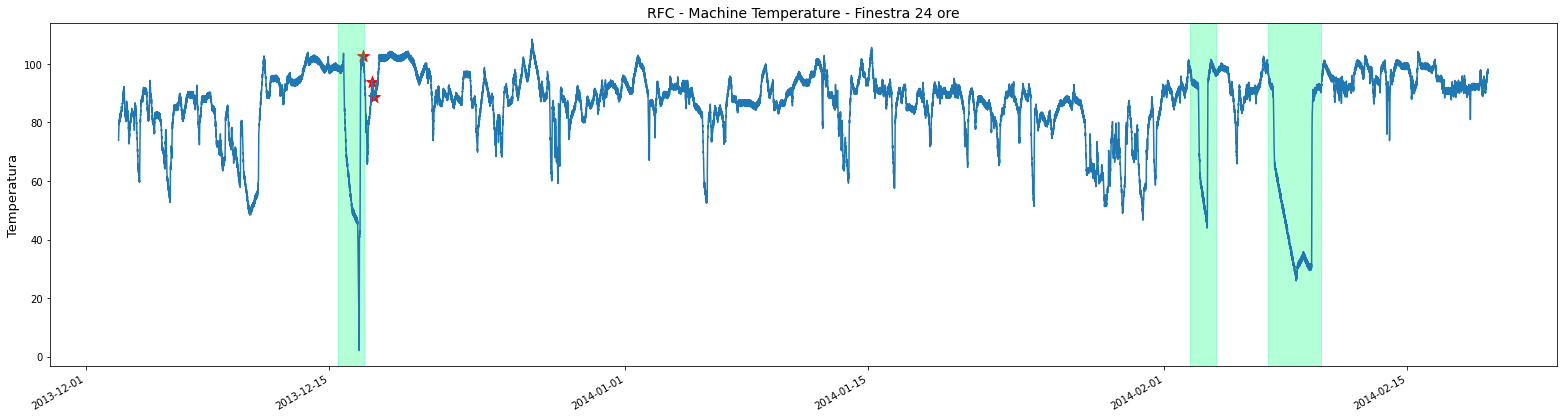

In [21]:
fig, ax = plt.subplots(1, figsize=(27, 7))
(temperature['value']).plot(ax=ax)
#avg_codisp.plot(ax=ax, color='red')
ax.scatter(first3.index, temperature['value'][first3.index], color='red', marker='*', s=150)

for event, duration in events.items():
    start, end = duration
    ax.axvspan(start, end, alpha=0.3,
                  color='springgreen')

ax.set_xlabel('')

ax.set_ylabel('Temperatura', size=13)
ax.set_title('RFC - Machine Temperature - Finestra 24 ore',size=14)

fig.savefig('RCF_MachineTemperature_24H.png')
plt.show()